In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Datasets

## Loading Data Incendie


In [2]:
df_incendie= pd.read_csv('./Data/Incendies.csv', sep=';', header=3)
df_incendie.shape

(27785, 24)

In [3]:
df_incendie.columns

Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune',
       'Date de première alerte', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       'Type de peuplement', 'Nature', 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits', 'Précision de la donnée'],
      dtype='object')

In [4]:
df_incendie['Date de première alerte'] = pd.to_datetime(df_incendie['Date de première alerte'], errors='coerce')

In [5]:
df_incendie['Code INSEE'] = df_incendie['Code INSEE'].astype(str).str.zfill(5)

## Cleaning Data Incendie

In [6]:
df_incendie.rename(columns={
    'Code INSEE': 'code_insee',
    'Date de première alerte': 'date',
    'Surface parcourue (m2)': 'surf_brulee',
    'Surface forêt (m2)': 'surf_foret',
    'Surface maquis garrigues (m2)': 'surf_maquis',
    'Autres surfaces naturelles hors forêt (m2)': 'surf_autres_naturelles',
    'Surfaces agricoles (m2)': 'surf_agri',
    'Autres surfaces (m2)': 'surf_autres',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_nat',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artif',
    'Surfaces non boisées (m2)': 'surf_nb_totale',
    'Type de peuplement': 'type_peuplement',
    'Nature': 'cause'
}, inplace=True)


In [7]:
colonnes_surfaces = [col for col in df_incendie.columns if 'surf' in col]
df_incendie[colonnes_surfaces] = df_incendie[colonnes_surfaces].fillna(0)

In [8]:
# Surface végétale potentielle (forêt + maquis + autres terres boisées)
df_incendie['surf_vegetale'] = (
    df_incendie['surf_foret'] +
    df_incendie['surf_maquis'] +
    df_incendie['surf_autres_bois']
)

# Ratio de végétation par rapport à la surface brûlée
df_incendie['ratio_vegetale'] = df_incendie['surf_vegetale'] / df_incendie['surf_brulee'].replace(0, 1)

df_incendie.head()


,Année,Numéro,Département,code_insee,Nom de la commune,date,surf_brulee,surf_foret,surf_maquis,surf_autres_naturelles,...,Précision des surfaces,type_peuplement,cause,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée,surf_vegetale,ratio_vegetale
0,2015,5769,66,66100,Llo,2015-01-01 00:09:00,5000,5000.0,0.0,0.0,...,0,4.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,5000.0,1.0
1,2015,6760,07,07176,Planzolles,2015-01-01 13:13:00,10000,0.0,10000.0,0.0,...,0,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,10000.0,1.0
2,2015,12057,2A,2A362,Zonza,2015-01-01 15:16:00,4000,0.0,4000.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,1.0
3,2015,6978,34,34260,Saint-Gervais-sur-Mare,2015-01-02 14:13:00,6450,6450.0,0.0,0.0,...,0,3.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN,6450.0,1.0
4,2015,2,12,12270,Sévérac-le-Château,2015-01-02 19:19:00,50,0.0,0.0,50.0,...,Estimées,NaN,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,50.0,1.0


## Loading Data Meteo

In [9]:
df_meteo = pd.read_csv('Data/meteo.csv', sep=';')
df_meteo.shape

(14811, 60)

In [10]:
df_meteo.columns

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59'],
      dtype='object')

In [11]:
# Sélection des colonnes utiles
df_meteo = df_meteo[['numer_sta', 'date', 'ff', 'raf10', 't', 'u', 'rr24']]

df_meteo['date'] = pd.to_datetime(df_meteo['date'].astype(str), format='%Y%m%d%H%M%S', errors='coerce')

cols_meteo = ['ff', 'raf10', 't', 'u', 'rr24']

# Remplacer 'mq' par NaN, puis convertir proprement en float
for col in cols_meteo:
    df_meteo[col] = pd.to_numeric(df_meteo[col].replace('mq', pd.NA), errors='coerce')
    
df_meteo.head()

,numer_sta,date,ff,raf10,t,u,rr24
0,7005,2015-01-01,2.8,3.6,272.55,89.0,0.0
1,7015,2015-01-01,2.4,3.0,272.85,100.0,0.0
2,7020,2015-01-01,10.8,15.1,279.95,88.0,0.0
3,7027,2015-01-01,2.8,3.4,270.65,92.0,0.0
4,7037,2015-01-01,1.3,1.9,270.65,95.0,0.0


In [12]:
# Pour température et humidité → remplacement simple
df_meteo['t'].fillna(df_meteo['t'].mean(), inplace=True)
df_meteo['u'].fillna(df_meteo['u'].mean(), inplace=True)

# Pour vitesse du vent (ff) → très peu de NaNs → suppression
df_meteo = df_meteo[df_meteo['ff'].notna()]

# Pour rafale (raf10) et pluie (rr24) → remplissage conservatif par 0
df_meteo['raf10'].fillna(0, inplace=True)
df_meteo['rr24'].fillna(0, inplace=True)

df_meteo.head()

C:\Users\sarah\AppData\Local\Temp\ipykernel_28184\1796571257.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meteo['t'].fillna(df_meteo['t'].mean(), inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_28184\1796571257.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,numer_sta,date,ff,raf10,t,u,rr24
0,7005,2015-01-01,2.8,3.6,272.55,89.0,0.0
1,7015,2015-01-01,2.4,3.0,272.85,100.0,0.0
2,7020,2015-01-01,10.8,15.1,279.95,88.0,0.0
3,7027,2015-01-01,2.8,3.4,270.65,92.0,0.0
4,7037,2015-01-01,1.3,1.9,270.65,95.0,0.0


In [13]:
df_meteo.info

<bound method DataFrame.info of        numer_sta                date    ff  raf10       t      u  rr24
0           7005 2015-01-01 00:00:00   2.8    3.6  272.55   89.0   0.0
1           7015 2015-01-01 00:00:00   2.4    3.0  272.85  100.0   0.0
2           7020 2015-01-01 00:00:00  10.8   15.1  279.95   88.0   0.0
3           7027 2015-01-01 00:00:00   2.8    3.4  270.65   92.0   0.0
4           7037 2015-01-01 00:00:00   1.3    1.9  270.65   95.0   0.0
...          ...                 ...   ...    ...     ...    ...   ...
14806      81401 2015-01-31 21:00:00   3.1    6.1  299.95   79.0   0.8
14807      81405 2015-01-31 21:00:00   5.8    8.2  300.65   77.0   2.8
14808      81408 2015-01-31 21:00:00   2.0    4.1  300.55   80.0  11.0
14809      81415 2015-01-31 21:00:00   0.6    1.9  298.75   91.0   2.8
14810      89642 2015-01-31 21:00:00   6.7    0.0  267.56   56.0   0.0

[14690 rows x 7 columns]>

## Loading Data Station_meteo

In [14]:
stations = pd.read_csv("./Data/meteo_station.txt", sep=';', encoding='utf-8')
stations.head()

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151


In [15]:
# 1. Nettoyage et renommage
df_stations = stations.copy()
df_stations.rename(columns={
    'ID': 'numer_sta',
    'Nom': 'nom_station',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace=True)

# 2. Création de la géométrie (EPSG:4326 = WGS84)
geometry = gpd.points_from_xy(df_stations['longitude'], df_stations['latitude'])
df_stations = gpd.GeoDataFrame(df_stations, geometry=geometry, crs='epsg:4326')

# Aperçu
df_stations.head()

,numer_sta,nom_station,latitude,longitude,Altitude,geometry
0,7005,ABBEVILLE,50.136000,1.834000,69,POINT (1.834 50.136)
1,7015,LILLE-LESQUIN,50.570000,3.097500,47,POINT (3.0975 50.57)
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67,POINT (-0.45617 49.18)
4,7037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.383)


In [16]:
df_meteo = df_meteo.merge(
    df_stations[['numer_sta', 'nom_station', 'geometry']],
    on='numer_sta',
    how='left'
)

df_meteo.tail()

,numer_sta,date,ff,raf10,t,u,rr24,nom_station,geometry
14685,81401,2015-01-31 21:00:00,3.1,6.1,299.95,79.0,0.8,SAINT LAURENT,POINT (-54.03167 5.4855)
14686,81405,2015-01-31 21:00:00,5.8,8.2,300.65,77.0,2.8,CAYENNE-MATOURY,POINT (-52.36533 4.82233)
14687,81408,2015-01-31 21:00:00,2.0,4.1,300.55,80.0,11.0,SAINT GEORGES,POINT (-51.80467 3.89067)
14688,81415,2015-01-31 21:00:00,0.6,1.9,298.75,91.0,2.8,MARIPASOULA,POINT (-54.02833 3.64017)
14689,89642,2015-01-31 21:00:00,6.7,0.0,267.56,56.0,0.0,DUMONT D'URVILLE,POINT (140.001 -66.66317)


## Loading Data Communes

In [17]:
df_commune = gpd.read_file('./Data/commune.shp')  

print(df_commune.columns)
df_commune.head()

Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
       'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'geometry'],
      dtype='object')


,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry
0,COMMUNE_0000000009738132,Guerlesquin,GUERLESQUIN,29067,Commune simple,1273,20,3,29,53,242900835,"POLYGON ((-3.59931 48.55848, -3.5991 48.558, -..."
1,COMMUNE_0000000009754553,Saint-Astier,SAINT-ASTIER,24372,Commune simple,5320,17,3,24,75,200040095,"POLYGON ((0.46243 45.15564, 0.46239 45.15582, ..."
2,COMMUNE_0000000009729885,Balan,BALAN,08043,Commune simple,1612,16,3,08,44,200041630,"POLYGON ((4.95473 49.67238, 4.95432 49.67251, ..."
3,COMMUNE_0000000009744647,Vallons-de-l'Erdre,VALLONS-DE-L'ERDRE,44180,Commune simple,6559,01,5,44,52,244400552,"POLYGON ((-1.03906 47.54917, -1.03896 47.54892..."
4,COMMUNE_0000000009745513,Loireauxence,LOIREAUXENCE,44213,Commune simple,7517,01,5,44,52,244400552,"POLYGON ((-1.07254 47.50173, -1.07199 47.50199..."


In [18]:
df_commune = df_commune[['INSEE_COM', 'NOM', 'POPULATION', 'geometry']].copy()
df_commune.rename(columns={
    'INSEE_COM': 'code_insee',
    'NOM': 'nom_commune'
}, inplace=True)

df_commune['code_insee'] = df_commune['code_insee'].astype(str).str.zfill(5)

# 1. Définir le CRS d'origine si absent (probablement Lambert 93)
df_commune.set_crs(epsg=2154, inplace=True)

# 2. Convertir vers WGS84 (EPSG:4326)
df_commune = df_commune.to_crs(epsg=4326)


df_commune.head()

,code_insee,nom_commune,POPULATION,geometry
0,29067,Guerlesquin,1273,"POLYGON ((-1.36312 -5.98356, -1.36312 -5.98356..."
1,24372,Saint-Astier,5320,"POLYGON ((-1.36309 -5.98357, -1.36309 -5.98357..."
2,08043,Balan,1612,"POLYGON ((-1.36307 -5.98355, -1.36307 -5.98355..."
3,44180,Vallons-de-l'Erdre,6559,"POLYGON ((-1.3631 -5.98356, -1.3631 -5.98356, ..."
4,44213,Loireauxence,7517,"POLYGON ((-1.3631 -5.98356, -1.3631 -5.98356, ..."


# Models

## Data Fusion 1

In [19]:
df_incendie1 = pd.read_csv('./Data/Incendies.csv', sep=';', header=3)
colonnes_utiles = [
    'Année',
    'Numéro',
    'Département',
    'Code INSEE',
    'Date de première alerte',
    'Surface parcourue (m2)',  
    'Surface forêt (m2)',
    'Surface maquis garrigues (m2)',
    'Autres surfaces naturelles hors forêt (m2)',
    'Surface autres terres boisées (m2)',
    'Surfaces non boisées naturelles (m2)',
    'Surfaces non boisées artificialisées (m2)',
    'Surfaces non boisées (m2)'
]

incendie = df_incendie1[colonnes_utiles].copy()

In [20]:
incendie.fillna(0, inplace=True)
# Suppression des colonnes redondantes après fusion manuelle des surfaces boisées et non boisées
incendie.drop(['Surface autres terres boisées (m2)','Surfaces non boisées (m2)'], axis=1, inplace=True)

incendie.rename(columns={
    'Année': 'annee',
    'Numéro': 'id_inc',
    'Département': 'dep',
    'Code INSEE': 'code_insee',
    'Date de première alerte': 'date',
    'Surface parcourue (m2)': 'surf_brulee',
    'Surface forêt (m2)': 'surf_foret',
    'Surface maquis garrigues (m2)': 'surf_maquis',
    'Autres surfaces naturelles hors forêt (m2)': 'autre_surf',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_naturelle',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artificielle',
    'Surfaces non boisées (m2)': 'surf_nb_totale'
}, inplace=True)


incendie.drop_duplicates(['date','id_inc']).shape

incendie.drop_duplicates(['code_insee','id_inc']).shape

# On enlève les départements corses
incendie = incendie[~incendie['code_insee'].astype(str).str.startswith(('2A', '2B'))]

# On convertit la colonne code_insee en entier
incendie['code_insee'] = incendie['code_insee'].astype(int)
# Regroupement des départements d’Île-de-France sous le code de Paris ('75'), comme dans les données IGN sauf pour la Seine-et-Marne 
incendie.loc[
    (incendie.dep == '75') |
    (incendie.dep == '91') |
    (incendie.dep == '92') |
    (incendie.dep == '93') |
    (incendie.dep == '94') |
    (incendie.dep == '95') |
    (incendie.dep == '78'),
    'dep'
] = '75'
# Convertir les dates en datetime
incendie['date'] = incendie.date.apply(lambda _: dt.datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))

In [21]:
df = incendie.copy()
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek

X = df[['dep', 'code_insee', 'surf_foret',
        'surf_nb_naturelle', 'surf_nb_artificielle',
      'month', 'day', 'dayofweek']].copy()

y = df['surf_brulee']

from sklearn.preprocessing import LabelEncoder
for col in ['dep', 'code_insee']:
    X[col] = LabelEncoder().fit_transform(X[col])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Modèle simple
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédictions
y_pred_lin = linreg.predict(X_test)

# Évaluation
print("Linear Regression")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_lin))
print("R²:", r2_score(y_test, y_pred_lin))

Linear Regression
Mean absolute Error: 43554.429075290725
R²: 0.9459409537037378


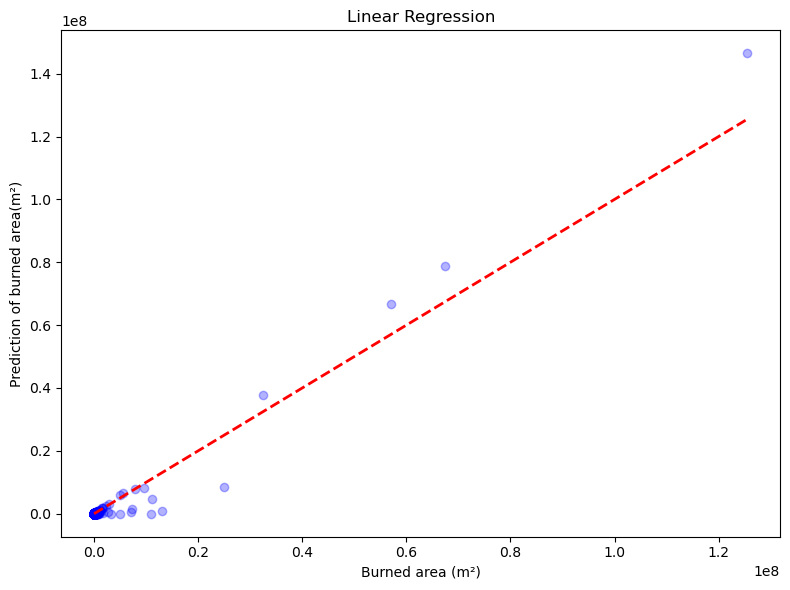

In [23]:
import matplotlib.pyplot as plt


y_pred_lin = linreg.predict(X_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Linear Regression")
plt.tight_layout()
plt.show()

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Modèle avancé
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
print("Random Forest Regressor")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest Regressor
Mean absolute Error: 53880.86700577883
R²: 0.7530067008675141


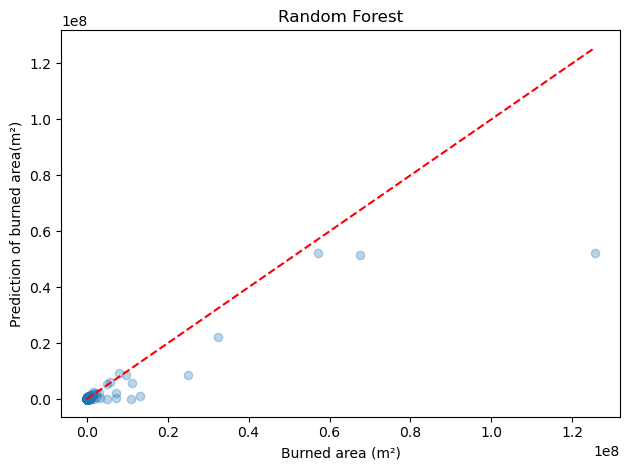

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

## Data Fusion 2

In [26]:
df_commune = df_commune.to_crs(epsg=4326)
df_stations = df_stations.to_crs(epsg=4326)
from scipy.spatial import cKDTree
import numpy as np

# Extraire les coordonnées
commune_coords = np.array(list(df_commune.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
station_coords = np.array(list(df_stations.geometry.apply(lambda geom: (geom.x, geom.y))))

# Construction du KDTree et recherche de la plus proche
tree = cKDTree(station_coords)
distances, indices = tree.query(commune_coords, k=1)

# Ajouter l'identifiant de la station la plus proche
df_commune['nearest_station'] = df_stations.iloc[indices]['numer_sta'].values.astype(int)

C:\Users\sarah\AppData\Local\Temp\ipykernel_28184\1005048656.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_coords = np.array(list(df_commune.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))


In [27]:
import pandas as pd

# 1. Nettoyage des colonnes INSEE et station
df_commune['code_insee'] = df_commune['code_insee'].astype(str).str.zfill(5)
df_commune['nearest_station'] = df_commune['nearest_station'].astype(int)
df_meteo['numer_sta'] = df_meteo['numer_sta'].astype(int)

# 2. Conversion des dates
df_meteo['date'] = pd.to_datetime(df_meteo['date'], errors='coerce')
df_incendie['date'] = pd.to_datetime(df_incendie['date'], errors='coerce')

# 3. Création de df_meteo_clean (colonnes utiles)
df_meteo_clean = df_meteo[['numer_sta', 'date', 'ff', 'raf10', 't', 'u', 'rr24']].copy()

# 4. Base commune avec stations météo les plus proches
df_base = df_commune[['code_insee', 'nearest_station']].copy()

# 5. Fusion : produit croisé (commune × chaque jour de météo de sa station)
df_commune_meteo = df_base.merge(
    df_meteo_clean,
    left_on='nearest_station',
    right_on='numer_sta',
    how='left'
)

# 6. Nettoyage des lignes sans date (par sécurité)
df_commune_meteo = df_commune_meteo[df_commune_meteo['date'].notna()]
df_incendie = df_incendie[df_incendie['date'].notna()]

In [28]:
# Base commune
df_base = df_commune[['code_insee', 'nearest_station']].copy()

# Fusion : produit croisé commune × météo de sa station
df_commune_meteo = df_base.merge(
    df_meteo_clean,
    left_on='nearest_station',
    right_on='numer_sta',
    how='left'
)

# Supprimer les lignes sans date
df_commune_meteo = df_commune_meteo[df_commune_meteo['date'].notna()]


In [29]:
# Harmoniser les codes INSEE
df_incendie['code_insee'] = df_incendie['code_insee'].astype(str).str.zfill(5)

# Créer une clé : code_insee + date
df_incendie['key'] = df_incendie['code_insee'] + '_' + df_incendie['date'].dt.strftime('%Y-%m-%d')
df_commune_meteo['key'] = df_commune_meteo['code_insee'] + '_' + df_commune_meteo['date'].dt.strftime('%Y-%m-%d')

# Génération du label (1 si incendie dans la commune ce jour-là)
df_commune_meteo['label'] = df_commune_meteo['key'].isin(df_incendie['key']).astype(int)

In [30]:
print(df_commune_meteo['label'].value_counts())
print(df_commune_meteo[['date', 'label']].drop_duplicates().head())

label
0    8663136
1        744
Name: count, dtype: int64
                 date  label
0 2015-01-01 00:00:00      0
1 2015-01-01 03:00:00      0
2 2015-01-01 06:00:00      0
3 2015-01-01 09:00:00      0
4 2015-01-01 12:00:00      0


In [31]:
# Définir les colonnes features
features = ['ff', 'raf10', 't', 'u', 'rr24']

# Supprimer les lignes avec valeurs manquantes
df_model = df_commune_meteo.dropna(subset=features + ['label'])

# Créer X et y
X = df_model[features]
y = df_model['label']
# Séparer les classes
df_positives = df_model[df_model['label'] == 1]
df_negatives = df_model[df_model['label'] == 0].sample(n=len(df_positives), random_state=42)

# Fusionner et mélanger
df_balanced = pd.concat([df_positives, df_negatives]).sample(frac=1, random_state=42)

# Redéfinir X et y équilibrés
X_balanced = df_balanced[features]
y_balanced = df_balanced['label']

In [32]:
def display_model_results(auc, report, matrix, name):
    print(f"\nÉvaluation {name}\nROC AUC : {auc:.3f}\n\n{report}\n")
    return pd.DataFrame(matrix, index=["Classe 0", "Classe 1"], columns=["Prédit 0", "Prédit 1"])

## Random Forest Classification

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Split train/test
X_train_RFC, X_test_RFC, y_train_RFC, y_test_RFC = train_test_split(X_balanced, y_balanced, stratify=y_balanced, test_size=0.2, random_state=42)

# Modèle
model_RFC = RandomForestClassifier(n_estimators=100, random_state=42)
model_RFC.fit(X_train_RFC, y_train_RFC)

# Prédiction + évaluation
y_pred_RFC = model_RFC.predict(X_test_RFC)
y_proba_RFC = model_RFC.predict_proba(X_test_RFC)[:, 1]

In [34]:
display_model_results(roc_auc_score(y_test_RFC, y_proba_RFC), classification_report(y_test_RFC, y_pred_RFC), confusion_matrix(y_test_RFC, y_pred_RFC), "Random Forest Classification")


Évaluation Random Forest Classification
ROC AUC : 0.690

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       149
           1       0.65      0.68      0.67       149

    accuracy                           0.66       298
   macro avg       0.66      0.66      0.66       298
weighted avg       0.66      0.66      0.66       298




,Prédit 0,Prédit 1
Classe 0,95,54
Classe 1,47,102


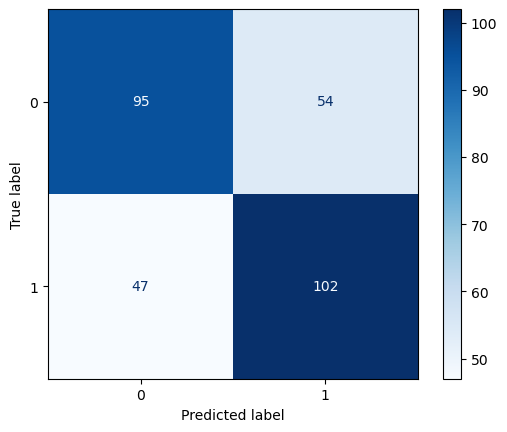

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_RFC, X_test_RFC, y_test_RFC, cmap='Blues')
plt.show()

## XGBoost

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_train_XGBC, X_test_XGBC, y_train_XGBC, y_test_XGBC = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

model_XGBC = XGBClassifier(eval_metric='logloss', random_state=42)
model_XGBC.fit(X_train_XGBC, y_train_XGBC)

y_pred_proba_XGBC = model_XGBC.predict_proba(X_test_XGBC)[:, 1]
y_pred_XGBC = model_XGBC.predict(X_test_XGBC)

In [37]:
display_model_results(roc_auc_score(y_test_XGBC, y_pred_proba_XGBC), 
                      classification_report(y_test_XGBC, y_pred_XGBC, output_dict=False), 
                      confusion_matrix(y_test_XGBC, y_pred_XGBC),
                      "XGBoost"
                     )


Évaluation XGBoost
ROC AUC : 0.694

              precision    recall  f1-score   support

           0       0.65      0.57      0.61       230
           1       0.60      0.68      0.64       217

    accuracy                           0.62       447
   macro avg       0.63      0.63      0.62       447
weighted avg       0.63      0.62      0.62       447




,Prédit 0,Prédit 1
Classe 0,132,98
Classe 1,70,147


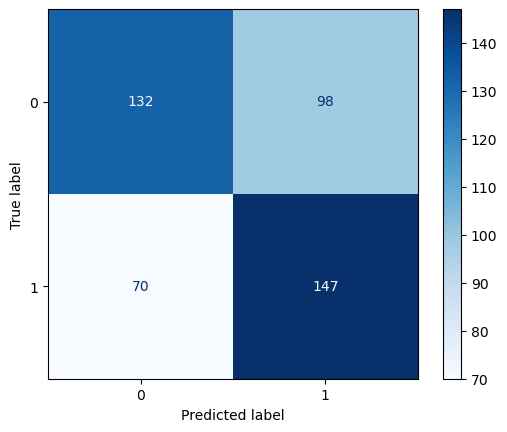

In [38]:
ConfusionMatrixDisplay.from_estimator(model_XGBC, X_test_XGBC, y_test_XGBC, cmap='Blues')
plt.show()

## LightGBM

In [39]:
!pip install lightgbm

In [40]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import pandas as pd
X_train_LGBMC, X_test_LGBMC, y_train_LGBMC, y_test_LGBMC = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Initialisation du modèle
model_LGBMC = LGBMClassifier(random_state=42)

# Entraînement
model_LGBMC.fit(X_train_LGBMC, y_train_LGBMC)

# Prédiction des classes et des probabilités
y_pred_LGBMC = model_LGBMC.predict(X_test_LGBMC)
y_proba_LGBMC = model_LGBMC.predict_proba(X_test_LGBMC)[:, 1]

[LightGBM] [Info] Number of positive: 527, number of negative: 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 1041, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506244 -> initscore=0.024977
[LightGBM] [Info] Start training from score 0.024977


In [41]:
display_model_results(
    roc_auc_score(y_test_LGBMC, y_proba_LGBMC), 
    classification_report(y_test_LGBMC, y_pred_LGBMC), 
    confusion_matrix(y_test_LGBMC, y_pred_LGBMC), 
    "LightGBM"
)


Évaluation LightGBM
ROC AUC : 0.702

              precision    recall  f1-score   support

           0       0.66      0.61      0.64       230
           1       0.62      0.66      0.64       217

    accuracy                           0.64       447
   macro avg       0.64      0.64      0.64       447
weighted avg       0.64      0.64      0.64       447




,Prédit 0,Prédit 1
Classe 0,141,89
Classe 1,73,144


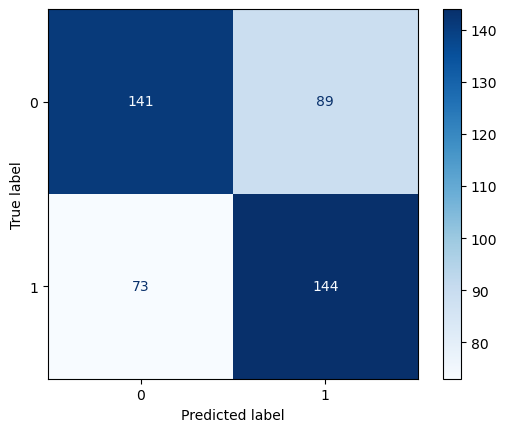

In [42]:
ConfusionMatrixDisplay.from_estimator(model_LGBMC, X_test_LGBMC, y_test_LGBMC, cmap='Blues')
plt.show()

# Vizualisation

 ## Map

In [43]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
len(df_commune)

34935

In [45]:
# Exclusion des departments d'outre mer
df_commune_metropole = df_commune[~df_commune["code_insee"].astype(str).str.startswith(("97", "98"))]

# Conversion en GeoDataFrame 
df_commune_geodata = gpd.GeoDataFrame(df_commune_metropole, geometry='geometry')

In [46]:
# Reprojeter les géométries dans un système de coordonnées projeté (ici : Lambert-93, EPSG:2154)
df_commune_geodata_proj = df_commune_geodata.to_crs(epsg=2154)

# Calculer les centroïdes dans ce système projeté (précis pour les calculs géométriques)
df_commune_geodata_proj['centroid'] = df_commune_geodata_proj.geometry.centroid

# Reprojeter les centroïdes dans un système géographique (latitude/longitude) EPSG:4326
df_commune_geodata_proj['centroid_latlon'] = df_commune_geodata_proj['centroid'].to_crs(epsg=4326)

# Extraire la latitude depuis le centroïde reprojeté
df_commune_geodata_proj['lat'] = df_commune_geodata_proj['centroid_latlon'].y

# Extraire la longitude depuis le centroïde reprojeté
df_commune_geodata_proj['lon'] = df_commune_geodata_proj['centroid_latlon'].x

In [53]:
# Échantillon pour commencer
nb_sample = 2000 #len(df_commune)
sample = df_commune_geodata_proj.sample(nb_sample, random_state=42).copy()

In [54]:
# Collecte les conditions météo pour un échantillon de commune
records = []

for _, row in tqdm(sample.iterrows(), total=len(sample)):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": row['lat'],
        "longitude": row['lon'],
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "wind_speed_10m",
            "wind_gusts_10m",
            "precipitation"
        ],
        "timezone": "auto"
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()

        if "hourly" not in data:
            continue

        i = 0  # heure actuelle ou prochaine
        record = {
            "code_insee": row['code_insee'],
            "nom_commune": row['nom_commune'],
            "date": data["hourly"]["time"][i],
            "t": data["hourly"]["temperature_2m"][i],
            "u": data["hourly"]["relative_humidity_2m"][i],
            "ff": data["hourly"]["wind_speed_10m"][i],
            "raf10": data["hourly"]["wind_gusts_10m"][i],
            "rr24": data["hourly"]["precipitation"][i],
            "numer_sta": 999999,
            "geometry": row['geometry']
        }
        records.append(record)

    except Exception as e:
        print(f"Erreur pour {row['nom_commune']} : {e}")
        continue

  4%|▎         | 74/2000 [00:16<57:46,  1.80s/it]

Erreur pour Lupstein : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  4%|▍         | 77/2000 [00:26<1:09:25,  2.17s/it]

Erreur pour Vassel : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  4%|▍         | 83/2000 [00:36<56:33,  1.77s/it]  

Erreur pour Maxilly-sur-SaÃ´ne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  4%|▍         | 87/2000 [00:45<1:00:57,  1.91s/it]

Erreur pour Houquetot : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▍         | 95/2000 [00:56<1:01:45,  1.95s/it]

Erreur pour Ancelle : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▍         | 96/2000 [01:05<1:44:38,  3.30s/it]

Erreur pour Arpheuilles : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▍         | 97/2000 [01:15<2:24:48,  4.57s/it]

Erreur pour Le Bosc : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▍         | 98/2000 [01:24<3:00:13,  5.69s/it]

Erreur pour Noisy-Rudignon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▌         | 102/2000 [01:34<2:05:42,  3.97s/it]

Erreur pour Beaurecueil : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▌         | 103/2000 [01:44<2:41:34,  5.11s/it]

Erreur pour Saxi-Bourdon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  5%|▌         | 107/2000 [01:53<1:44:26,  3.31s/it]

Erreur pour Bessay : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  6%|▌         | 110/2000 [02:03<1:32:29,  2.94s/it]

Erreur pour Bosc-le-Hard : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  7%|▋         | 134/2000 [02:15<48:02,  1.54s/it]  

Erreur pour CÃ©bazat : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  7%|▋         | 148/2000 [02:25<37:08,  1.20s/it]

Erreur pour VÃ©nissieux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  8%|▊         | 156/2000 [02:36<41:30,  1.35s/it]

Erreur pour Villard : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  8%|▊         | 164/2000 [02:46<55:28,  1.81s/it]

Erreur pour VandiÃ¨res : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  9%|▊         | 171/2000 [02:56<50:41,  1.66s/it]  

Erreur pour Mus : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  9%|▉         | 175/2000 [03:06<1:10:31,  2.32s/it]

Erreur pour Saint-Sigismond : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  9%|▉         | 178/2000 [03:16<1:17:42,  2.56s/it]

Erreur pour Luby-Betmont : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  9%|▉         | 182/2000 [03:25<1:08:43,  2.27s/it]

Erreur pour Le Raincy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


  9%|▉         | 187/2000 [03:35<1:01:16,  2.03s/it]

Erreur pour Lesseux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 10%|▉         | 196/2000 [03:46<46:45,  1.55s/it]  

Erreur pour Monestier-de-Clermont : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 10%|█         | 200/2000 [03:55<54:31,  1.82s/it]  

Erreur pour Chaumont-sur-Aire : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 10%|█         | 208/2000 [04:06<44:33,  1.49s/it]  

Erreur pour Coufouleux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 11%|█         | 214/2000 [04:16<59:14,  1.99s/it]

Erreur pour Beauvois-en-CambrÃ©sis : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 11%|█         | 217/2000 [04:25<1:06:36,  2.24s/it]

Erreur pour Montbazon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 11%|█▏        | 226/2000 [04:36<47:04,  1.59s/it]  

Erreur pour La Gaudaine : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 12%|█▏        | 242/2000 [04:47<34:58,  1.19s/it]

Erreur pour Pietroso : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 12%|█▏        | 246/2000 [04:57<47:31,  1.63s/it]  

Erreur pour Saint-Laurent-de-la-PrÃ©e : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 12%|█▏        | 248/2000 [05:06<1:15:33,  2.59s/it]

Erreur pour Ibos : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 12%|█▏        | 249/2000 [05:16<1:51:31,  3.82s/it]

Erreur pour Les Salces : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 13%|█▎        | 252/2000 [05:26<1:32:57,  3.19s/it]

Erreur pour Saint-Laurent-de-Mure : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 13%|█▎        | 254/2000 [05:35<1:49:06,  3.75s/it]

Erreur pour Montcheutin : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 13%|█▎        | 255/2000 [05:45<2:22:18,  4.89s/it]

Erreur pour Saint-Marcel-lÃ¨s-Annonay : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 14%|█▍        | 287/2000 [05:57<43:27,  1.52s/it]  

Erreur pour Puygaillard-de-Quercy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 14%|█▍        | 288/2000 [06:07<1:23:53,  2.94s/it]

Erreur pour Miniac-Morvan : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 15%|█▍        | 292/2000 [06:17<1:26:46,  3.05s/it]

Erreur pour OlliÃ¨res : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 15%|█▍        | 295/2000 [06:27<1:19:15,  2.79s/it]

Erreur pour Villenave-de-Rions : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 16%|█▌        | 315/2000 [06:38<44:23,  1.58s/it]  

Erreur pour Sainte-Eulalie-d'Ans : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 16%|█▌        | 321/2000 [06:48<1:22:38,  2.95s/it]

Erreur pour Malavillers : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 16%|█▌        | 323/2000 [06:58<1:36:39,  3.46s/it]

Erreur pour Beauvilliers : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 17%|█▋        | 335/2000 [07:08<46:43,  1.68s/it]  

Erreur pour Thorey-Lyautey : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 18%|█▊        | 350/2000 [07:10<03:36,  7.61it/s]

Erreur pour Bois-Guilbert : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 18%|█▊        | 352/2000 [07:29<1:27:59,  3.20s/it]

Erreur pour Reboursin : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 19%|█▉        | 382/2000 [07:43<40:22,  1.50s/it]  

Erreur pour Villeneuve-sur-VÃ¨re : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 20%|█▉        | 396/2000 [07:54<43:47,  1.64s/it]  

Erreur pour PlombiÃ¨res-lÃ¨s-Dijon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 20%|█▉        | 399/2000 [08:04<1:17:38,  2.91s/it]

Erreur pour Guipry-Messac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 20%|██        | 400/2000 [08:13<2:00:06,  4.50s/it]

Erreur pour La Loge-aux-ChÃ¨vres : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 20%|██        | 403/2000 [08:23<1:36:09,  3.61s/it]

Erreur pour MerlÃ©ac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 20%|██        | 408/2000 [08:33<1:03:31,  2.39s/it]

Erreur pour Aghione : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 21%|██        | 416/2000 [08:43<42:06,  1.59s/it]  

Erreur pour Chevillon-sur-Huillard : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 21%|██▏       | 426/2000 [08:54<46:16,  1.76s/it]

Erreur pour Ãvres : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 21%|██▏       | 427/2000 [09:03<1:22:36,  3.15s/it]

Erreur pour SÃ©ry-Magneval : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 431/2000 [09:13<1:06:18,  2.54s/it]

Erreur pour ChÃ¨ze : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 435/2000 [09:23<59:16,  2.27s/it]  

Erreur pour Hibarette : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 439/2000 [09:33<1:07:13,  2.58s/it]

Erreur pour ChÃ¢telus : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 442/2000 [09:42<1:06:39,  2.57s/it]

Erreur pour Terramesnil : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 445/2000 [09:52<1:23:50,  3.24s/it]

Erreur pour Bertrichamps : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|██▏       | 449/2000 [10:02<1:06:07,  2.56s/it]

Erreur pour Conteville : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 23%|██▎       | 457/2000 [10:12<42:33,  1.65s/it]  

Erreur pour Courseulles-sur-Mer : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 24%|██▍       | 477/2000 [10:23<39:27,  1.55s/it]

Erreur pour Chassagne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 24%|██▍       | 482/2000 [10:33<44:35,  1.76s/it]  

Erreur pour La Chapelle-Saint-Laurian : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 24%|██▍       | 485/2000 [10:43<1:10:21,  2.79s/it]

Erreur pour Urmatt : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 24%|██▍       | 486/2000 [10:53<1:46:29,  4.22s/it]

Erreur pour Farnay : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 24%|██▍       | 489/2000 [11:02<1:28:50,  3.53s/it]

Erreur pour Montreuil-le-ChÃ©tif : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 25%|██▍       | 491/2000 [11:12<1:33:46,  3.73s/it]

Erreur pour Aulnois-sur-Seille : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 26%|██▌       | 517/2000 [11:24<31:54,  1.29s/it]  

Erreur pour Marle : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 26%|██▌       | 519/2000 [11:34<57:32,  2.33s/it]  

Erreur pour Brignac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 26%|██▌       | 524/2000 [11:44<46:36,  1.89s/it]  

Erreur pour Trizay-lÃ¨s-Bonneval : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 26%|██▋       | 530/2000 [11:54<45:37,  1.86s/it]  

Erreur pour Servais : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 27%|██▋       | 535/2000 [12:04<1:02:55,  2.58s/it]

Erreur pour Goxwiller : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 27%|██▋       | 542/2000 [12:14<44:01,  1.81s/it]  

Erreur pour Avenay-Val-d'Or : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 27%|██▋       | 548/2000 [12:24<48:11,  1.99s/it]  

Erreur pour EstrÃ©e-Blanche : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 28%|██▊       | 557/2000 [12:34<41:15,  1.72s/it]  

Erreur pour GuÃ©bling : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 28%|██▊       | 561/2000 [12:44<58:07,  2.42s/it]

Erreur pour Saint-Ãtienne-du-GrÃ¨s : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 28%|██▊       | 564/2000 [12:54<59:27,  2.48s/it]  

Erreur pour Bunus : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 28%|██▊       | 568/2000 [13:04<1:04:30,  2.70s/it]

Erreur pour Montdidier : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 28%|██▊       | 570/2000 [13:13<1:15:42,  3.18s/it]

Erreur pour CourpiÃ¨re : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 29%|██▉       | 577/2000 [13:23<49:29,  2.09s/it]  

Erreur pour Labastide-Esparbairenque : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 29%|██▉       | 580/2000 [13:33<55:31,  2.35s/it]  

Erreur pour Ãpieds : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 29%|██▉       | 585/2000 [13:43<47:49,  2.03s/it]  

Erreur pour Essertines-en-Donzy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 30%|███       | 601/2000 [13:54<37:41,  1.62s/it]

Erreur pour Honguemare-Guenouville : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 31%|███       | 615/2000 [14:05<27:53,  1.21s/it]

Erreur pour Levier : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 32%|███▏      | 632/2000 [14:16<28:30,  1.25s/it]

Erreur pour Besse-et-Saint-Anastaise : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 32%|███▏      | 635/2000 [14:26<45:03,  1.98s/it]

Erreur pour Lainsecq : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 32%|███▏      | 646/2000 [14:36<40:24,  1.79s/it]

Erreur pour Saint-Romain-de-Lerps : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 33%|███▎      | 655/2000 [14:47<35:20,  1.58s/it]

Erreur pour Sonchamp : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 33%|███▎      | 669/2000 [14:58<26:36,  1.20s/it]

Erreur pour Le Pin-la-Garenne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 34%|███▎      | 673/2000 [15:08<42:55,  1.94s/it]

Erreur pour Mouzens : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 34%|███▍      | 681/2000 [15:18<40:28,  1.84s/it]

Erreur pour Toury : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 34%|███▍      | 683/2000 [15:27<1:05:13,  2.97s/it]

Erreur pour Champosoult : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 34%|███▍      | 685/2000 [15:37<1:19:23,  3.62s/it]

Erreur pour Bourg-Sainte-Marie : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 35%|███▍      | 692/2000 [15:48<54:18,  2.49s/it]  

Erreur pour Ãtival-lÃ¨s-le-Mans : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 35%|███▍      | 695/2000 [15:58<54:46,  2.52s/it]  

Erreur pour Sainte-Colombe : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 35%|███▌      | 704/2000 [16:08<37:06,  1.72s/it]

Erreur pour CrÃ©ot : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 36%|███▌      | 718/2000 [16:19<35:14,  1.65s/it]

Erreur pour PÅuilly : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 36%|███▌      | 719/2000 [16:28<1:05:22,  3.06s/it]

Erreur pour Saint-Jean-de-Thurigneux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 36%|███▌      | 723/2000 [16:38<53:05,  2.49s/it]  

Erreur pour Sainte-Fortunade : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 37%|███▋      | 745/2000 [16:40<02:49,  7.41it/s]

Erreur pour Saint-Lary : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 37%|███▋      | 748/2000 [17:00<51:20,  2.46s/it]  

Erreur pour Bernac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 38%|███▊      | 750/2000 [17:09<1:07:45,  3.25s/it]

Erreur pour MÃ©nil : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 38%|███▊      | 753/2000 [17:19<1:00:31,  2.91s/it]

Erreur pour Combrand : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 39%|███▉      | 776/2000 [17:31<23:02,  1.13s/it]  

Erreur pour Les SoriniÃ¨res : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 39%|███▉      | 783/2000 [17:41<30:01,  1.48s/it]

Erreur pour Charnay-lÃ¨s-Chalon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 40%|███▉      | 790/2000 [17:51<31:46,  1.58s/it]

Erreur pour Saint-Urcisse : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 40%|███▉      | 798/2000 [18:01<28:45,  1.44s/it]

Erreur pour Hon-Hergies : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 41%|████      | 820/2000 [18:12<30:10,  1.53s/it]

Erreur pour Freyming-Merlebach : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 42%|████▏     | 831/2000 [18:23<25:17,  1.30s/it]

Erreur pour Gensac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 42%|████▏     | 841/2000 [18:33<24:48,  1.28s/it]

Erreur pour Druillat : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 42%|████▏     | 842/2000 [18:43<53:05,  2.75s/it]

Erreur pour Saint-AndrÃ©-Goule-d'Oie : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 42%|████▏     | 846/2000 [18:52<45:19,  2.36s/it]  

Erreur pour Saubrigues : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 42%|████▏     | 847/2000 [19:02<1:11:18,  3.71s/it]

Erreur pour Ãpinonville : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 43%|████▎     | 851/2000 [19:12<52:55,  2.76s/it]  

Erreur pour Albertville : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 43%|████▎     | 856/2000 [19:22<42:01,  2.20s/it]  

Erreur pour Saint-Hilaire-Fontaine : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 46%|████▋     | 929/2000 [19:38<19:24,  1.09s/it]

Erreur pour Pont-d'Ouilly : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 47%|████▋     | 935/2000 [19:48<25:17,  1.43s/it]

Erreur pour Roumare : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 47%|████▋     | 941/2000 [19:58<29:49,  1.69s/it]

Erreur pour Saint-Michel-de-PlÃ©lan : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 47%|████▋     | 945/2000 [20:08<33:09,  1.89s/it]

Erreur pour Petite-Rosselle : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 48%|████▊     | 955/2000 [20:18<31:32,  1.81s/it]

Erreur pour Entre-deux-Monts : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 48%|████▊     | 967/2000 [20:29<29:28,  1.71s/it]

Erreur pour Salzuit : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 48%|████▊     | 968/2000 [20:38<53:18,  3.10s/it]

Erreur pour Lathuile : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 48%|████▊     | 970/2000 [20:48<59:06,  3.44s/it]  

Erreur pour SaÃ´ne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 49%|████▉     | 989/2000 [20:59<26:59,  1.60s/it]

Erreur pour Rauville-la-Bigot : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 50%|████▉     | 993/2000 [21:09<30:38,  1.83s/it]

Erreur pour Le Thor : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 50%|████▉     | 994/2000 [21:19<53:36,  3.20s/it]

Erreur pour Durstel : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 50%|████▉     | 996/2000 [21:29<58:41,  3.51s/it]  

Erreur pour Montastruc : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 51%|█████▏    | 1028/2000 [21:41<24:34,  1.52s/it]

Erreur pour Recurt : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1032/2000 [21:51<28:44,  1.78s/it]

Erreur pour La Vieille-Loye : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1033/2000 [22:00<50:49,  3.15s/it]

Erreur pour Attin : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1035/2000 [22:10<59:42,  3.71s/it]

Erreur pour Palogneux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1036/2000 [22:19<1:17:47,  4.84s/it]

Erreur pour Theix-Noyalo : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1039/2000 [22:29<58:32,  3.66s/it]  

Erreur pour Feuguerolles-Bully : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 52%|█████▏    | 1044/2000 [22:39<39:19,  2.47s/it]  

Erreur pour Saint-Jacques-sur-DarnÃ©tal : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 53%|█████▎    | 1060/2000 [22:41<03:13,  4.86it/s]

Erreur pour Braux-Sainte-CohiÃ¨re : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 53%|█████▎    | 1064/2000 [23:00<33:26,  2.14s/it]

Erreur pour Val d'Oingt : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 53%|█████▎    | 1066/2000 [23:09<45:55,  2.95s/it]

Erreur pour Mandelieu-la-Napoule : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 53%|█████▎    | 1069/2000 [23:19<42:53,  2.76s/it]  

Erreur pour PlÃ©nisette : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 54%|█████▎    | 1073/2000 [23:29<41:02,  2.66s/it]

Erreur pour Lamothe-FÃ©nelon : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 54%|█████▍    | 1080/2000 [23:39<26:21,  1.72s/it]

Erreur pour Saint-Germain-des-Champs : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 54%|█████▍    | 1088/2000 [23:49<22:18,  1.47s/it]

Erreur pour BÃ©douÃ¨s-CocurÃ¨s : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 56%|█████▌    | 1110/2000 [24:01<22:46,  1.54s/it]

Erreur pour Montigny-Lengrain : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 56%|█████▌    | 1111/2000 [24:10<43:43,  2.95s/it]

Erreur pour Malegoude : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 56%|█████▌    | 1120/2000 [24:21<28:36,  1.95s/it]

Erreur pour Montreux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 57%|█████▋    | 1133/2000 [24:31<42:43,  2.96s/it]

Erreur pour PoillÃ©-sur-VÃ¨gre : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 57%|█████▋    | 1136/2000 [24:41<38:53,  2.70s/it]  

Erreur pour Saint-Vincent-de-Pertignas : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 57%|█████▋    | 1146/2000 [24:52<20:36,  1.45s/it]

Erreur pour Pouru-Saint-Remy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 58%|█████▊    | 1158/2000 [24:53<03:22,  4.17it/s]

Erreur pour La Tranche-sur-Mer : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 58%|█████▊    | 1164/2000 [25:14<33:00,  2.37s/it]

Erreur pour Fontaine-la-RiviÃ¨re : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 59%|█████▉    | 1176/2000 [25:24<24:23,  1.78s/it]

Erreur pour Lepuix-Neuf : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 59%|█████▉    | 1179/2000 [25:34<29:04,  2.13s/it]

Erreur pour Compans : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 60%|██████    | 1207/2000 [25:46<20:05,  1.52s/it]

Erreur pour Meunet-sur-Vatan : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 60%|██████    | 1208/2000 [25:55<38:46,  2.94s/it]

Erreur pour Tourves : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 60%|██████    | 1209/2000 [26:05<56:19,  4.27s/it]

Erreur pour Saint-Vigor-le-Grand : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 61%|██████    | 1212/2000 [26:15<44:09,  3.36s/it]  

Erreur pour Saint-Genest : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 62%|██████▏   | 1230/2000 [26:26<20:50,  1.62s/it]

Erreur pour Le Cendre : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 62%|██████▏   | 1236/2000 [26:36<20:30,  1.61s/it]

Erreur pour Limons : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 62%|██████▏   | 1241/2000 [26:46<22:32,  1.78s/it]

Erreur pour Maupertus-sur-Mer : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 63%|██████▎   | 1251/2000 [26:56<17:13,  1.38s/it]

Erreur pour Lachassagne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 63%|██████▎   | 1254/2000 [27:06<23:45,  1.91s/it]

Erreur pour Biriatou : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 63%|██████▎   | 1264/2000 [27:16<17:00,  1.39s/it]

Erreur pour Montesquieu : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 64%|██████▎   | 1274/2000 [27:27<21:08,  1.75s/it]

Erreur pour Tarabel : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 64%|██████▍   | 1277/2000 [27:37<32:45,  2.72s/it]

Erreur pour Moisselles : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 64%|██████▍   | 1286/2000 [27:47<24:03,  2.02s/it]

Erreur pour Saint-Pierre-de-MÃ©sage : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 64%|██████▍   | 1289/2000 [27:57<26:50,  2.27s/it]

Erreur pour Broussey-en-Blois : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 65%|██████▍   | 1297/2000 [28:07<18:32,  1.58s/it]

Erreur pour Beaufort-en-Argonne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 66%|██████▌   | 1313/2000 [28:09<01:57,  5.83it/s]

Erreur pour JuliÃ©nas : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 66%|██████▌   | 1317/2000 [28:28<24:07,  2.12s/it]

Erreur pour Jarcieu : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 66%|██████▌   | 1323/2000 [28:38<24:53,  2.21s/it]

Erreur pour Levroux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 67%|██████▋   | 1335/2000 [28:49<14:47,  1.33s/it]

Erreur pour Chamole : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 67%|██████▋   | 1338/2000 [28:58<27:20,  2.48s/it]

Erreur pour Coutansouze : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 67%|██████▋   | 1341/2000 [29:08<27:34,  2.51s/it]

Erreur pour Saint-Loup-des-Bois : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 68%|██████▊   | 1352/2000 [29:19<15:37,  1.45s/it]

Erreur pour Longchamp : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 68%|██████▊   | 1360/2000 [29:29<19:39,  1.84s/it]

Erreur pour Laneuveville-en-Saulnois : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 69%|██████▊   | 1374/2000 [29:30<02:23,  4.36it/s]

Erreur pour Monprimblanc : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 69%|██████▉   | 1376/2000 [29:49<31:31,  3.03s/it]

Erreur pour LariviÃ¨re : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 69%|██████▉   | 1379/2000 [29:59<29:05,  2.81s/it]

Erreur pour Villeloup : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 70%|██████▉   | 1391/2000 [30:09<18:26,  1.82s/it]

Erreur pour TrÃ©mÃ©ven : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 71%|███████   | 1424/2000 [30:22<10:27,  1.09s/it]

Erreur pour Bogny-sur-Meuse : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 71%|███████▏  | 1427/2000 [30:32<17:35,  1.84s/it]

Erreur pour Coincy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 72%|███████▏  | 1431/2000 [30:41<21:28,  2.26s/it]

Erreur pour Pavilly : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 72%|███████▏  | 1441/2000 [30:52<14:03,  1.51s/it]

Erreur pour Le Verdier : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 72%|███████▏  | 1447/2000 [30:52<04:38,  1.99it/s]

Erreur pour Coise-Saint-Jean-Pied-Gauthier : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 73%|███████▎  | 1451/2000 [31:12<21:26,  2.34s/it]

Erreur pour Petit-RÃ©derching : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 73%|███████▎  | 1453/2000 [31:21<28:18,  3.11s/it]

Erreur pour Gonneville-Le Theil : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 73%|███████▎  | 1460/2000 [31:31<23:28,  2.61s/it]

Erreur pour Marnay-sur-Marne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 73%|███████▎  | 1461/2000 [31:41<36:05,  4.02s/it]

Erreur pour SoyÃ©court : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 73%|███████▎  | 1465/2000 [31:51<25:32,  2.86s/it]

Erreur pour Hautbos : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 75%|███████▍  | 1499/2000 [32:03<12:38,  1.51s/it]

Erreur pour Pierrefitte-sur-Seine : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 75%|███████▌  | 1509/2000 [32:14<14:17,  1.75s/it]

Erreur pour Hauriet : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 76%|███████▌  | 1513/2000 [32:23<15:22,  1.89s/it]

Erreur pour FerriÃ¨re-sur-Beaulieu : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 76%|███████▌  | 1519/2000 [32:33<17:03,  2.13s/it]

Erreur pour RuffignÃ© : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 76%|███████▌  | 1523/2000 [32:43<16:33,  2.08s/it]

Erreur pour Wahlbach : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 77%|███████▋  | 1536/2000 [32:54<13:36,  1.76s/it]

Erreur pour Couvrelles : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 77%|███████▋  | 1544/2000 [33:04<14:31,  1.91s/it]

Erreur pour Arnave : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 77%|███████▋  | 1547/2000 [33:14<16:37,  2.20s/it]

Erreur pour La Neuville-lÃ¨s-Wasigny : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 78%|███████▊  | 1553/2000 [33:24<13:50,  1.86s/it]

Erreur pour Vitry-le-CroisÃ© : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 78%|███████▊  | 1561/2000 [33:34<11:35,  1.58s/it]

Erreur pour Marcillac-la-Croisille : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 79%|███████▊  | 1571/2000 [33:35<02:09,  3.30it/s]

Erreur pour Montagny-les-Lanches : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 79%|███████▉  | 1575/2000 [33:54<15:39,  2.21s/it]

Erreur pour L'OrÃ©e-d'Ãcouves : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 79%|███████▉  | 1585/2000 [34:05<12:53,  1.86s/it]

Erreur pour RenazÃ© : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|███████▉  | 1593/2000 [34:15<10:14,  1.51s/it]

Erreur pour TartÃ©court : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|███████▉  | 1596/2000 [34:24<17:21,  2.58s/it]

Erreur pour Givry-en-Argonne : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|███████▉  | 1597/2000 [34:34<26:45,  3.98s/it]

Erreur pour Sentenac-de-SÃ©rou : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|███████▉  | 1598/2000 [34:44<35:01,  5.23s/it]

Erreur pour Brouck : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|███████▉  | 1599/2000 [34:53<41:56,  6.27s/it]

Erreur pour Salonnes : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|████████  | 1602/2000 [35:03<29:20,  4.42s/it]

Erreur pour Blyes : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 80%|████████  | 1607/2000 [35:13<17:14,  2.63s/it]

Erreur pour Les Magnils-Reigniers : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 82%|████████▏ | 1639/2000 [35:25<06:33,  1.09s/it]

Erreur pour La Chapelle-Marcousse : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 82%|████████▏ | 1640/2000 [35:35<15:30,  2.59s/it]

Erreur pour VÃ©rissey : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 82%|████████▏ | 1641/2000 [35:44<23:52,  3.99s/it]

Erreur pour Blangy-sur-Bresle : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 82%|████████▏ | 1643/2000 [35:54<25:34,  4.30s/it]

Erreur pour Busloup : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 82%|████████▏ | 1647/2000 [36:04<17:51,  3.03s/it]

Erreur pour Germaines : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 83%|████████▎ | 1655/2000 [36:14<10:09,  1.77s/it]

Erreur pour Richebourg : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 83%|████████▎ | 1667/2000 [36:25<07:06,  1.28s/it]

Erreur pour Vourles : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 83%|████████▎ | 1669/2000 [36:34<12:55,  2.34s/it]

Erreur pour Englefontaine : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▎ | 1672/2000 [36:44<13:19,  2.44s/it]

Erreur pour Denain : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▎ | 1673/2000 [36:53<20:46,  3.81s/it]

Erreur pour Lamorlaye : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▍ | 1676/2000 [37:03<17:03,  3.16s/it]

Erreur pour Alos : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▍ | 1682/2000 [37:13<10:53,  2.06s/it]

Erreur pour Loos : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▍ | 1684/2000 [37:23<15:26,  2.93s/it]

Erreur pour Contre : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 84%|████████▍ | 1688/2000 [37:33<12:48,  2.46s/it]

Erreur pour Bourbach-le-Haut : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 88%|████████▊ | 1764/2000 [37:50<04:15,  1.08s/it]

Erreur pour La Salvetat-Belmontet : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 88%|████████▊ | 1768/2000 [37:59<06:04,  1.57s/it]

Erreur pour Cardaillac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 89%|████████▊ | 1774/2000 [38:09<09:20,  2.48s/it]

Erreur pour Dampierre : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 89%|████████▉ | 1778/2000 [38:19<08:13,  2.22s/it]

Erreur pour Mont : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 89%|████████▉ | 1780/2000 [38:29<12:51,  3.51s/it]

Erreur pour Squiffiec : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 89%|████████▉ | 1783/2000 [38:39<10:46,  2.98s/it]

Erreur pour Bois-de-Champ : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 89%|████████▉ | 1786/2000 [38:48<09:48,  2.75s/it]

Erreur pour Monthiers : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 90%|████████▉ | 1790/2000 [38:58<08:11,  2.34s/it]

Erreur pour Saint-Marcellin-lÃ¨s-Vaison : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 91%|█████████▏| 1826/2000 [39:11<03:09,  1.09s/it]

Erreur pour Natzwiller : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 92%|█████████▏| 1831/2000 [39:21<04:27,  1.58s/it]

Erreur pour Moustoir-Ac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 92%|█████████▏| 1836/2000 [39:31<06:32,  2.40s/it]

Erreur pour CorbÃ¨re-AbÃ¨res : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 92%|█████████▏| 1839/2000 [39:40<06:37,  2.47s/it]

Erreur pour Ascarat : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 92%|█████████▏| 1844/2000 [39:50<05:25,  2.09s/it]

Erreur pour Marsangy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 92%|█████████▏| 1849/2000 [40:00<04:55,  1.96s/it]

Erreur pour Nercillac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 93%|█████████▎| 1862/2000 [40:11<02:53,  1.26s/it]

Erreur pour Le Bizot : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 93%|█████████▎| 1868/2000 [40:21<03:16,  1.49s/it]

Erreur pour Belrupt : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 94%|█████████▍| 1884/2000 [40:32<02:14,  1.16s/it]

Erreur pour Prissac : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 94%|█████████▍| 1888/2000 [40:42<03:00,  1.61s/it]

Erreur pour Meaux : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 95%|█████████▌| 1902/2000 [40:52<02:40,  1.64s/it]

Erreur pour Saint-Palais : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 95%|█████████▌| 1903/2000 [41:02<04:54,  3.04s/it]

Erreur pour Verlin : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 95%|█████████▌| 1906/2000 [41:12<04:22,  2.79s/it]

Erreur pour Massongy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 96%|█████████▌| 1924/2000 [41:23<02:02,  1.61s/it]

Erreur pour Pargny-sous-Mureau : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 96%|█████████▋| 1928/2000 [41:33<02:11,  1.83s/it]

Erreur pour Fontaine-le-Comte : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 97%|█████████▋| 1936/2000 [41:43<01:35,  1.50s/it]

Erreur pour FrÃ©mÃ©nil : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 97%|█████████▋| 1938/2000 [41:52<02:34,  2.50s/it]

Erreur pour Grandchamp : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 97%|█████████▋| 1939/2000 [42:02<03:48,  3.74s/it]

Erreur pour Schweyen : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 97%|█████████▋| 1941/2000 [42:12<04:02,  4.10s/it]

Erreur pour Saint-Omer-Capelle : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 97%|█████████▋| 1945/2000 [42:21<02:44,  2.99s/it]

Erreur pour Challain-la-Potherie : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 98%|█████████▊| 1961/2000 [42:32<00:48,  1.24s/it]

Erreur pour Billy-sur-Oisy : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 99%|█████████▉| 1989/2000 [42:44<00:16,  1.52s/it]

Erreur pour Pierrevert : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|█████████▉| 1993/2000 [42:54<00:15,  2.21s/it]

Erreur pour Hodenc-l'ÃvÃªque : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|█████████▉| 1995/2000 [43:04<00:14,  2.82s/it]

Erreur pour Coudray : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|██████████| 2000/2000 [43:14<00:00,  1.30s/it]

Erreur pour BussiÃ¨res : ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


In [55]:
print("Date des conditions météo :")
for date in sorted(set(record['date'] for record in records)):
    print(date)

Date des conditions météo :
2025-05-26T00:00
2025-05-27T00:00


In [56]:
# Créer un GeoDataFrame avec les résultats
df_predict = pd.DataFrame(records)
gdf_predict = gpd.GeoDataFrame(df_predict, geometry="geometry")

In [57]:
# Appliquer le modèle
X_input = gdf_predict[X_train_LGBMC.columns]
gdf_predict["proba"] = model_LGBMC.predict_proba(X_input)[:, 1]

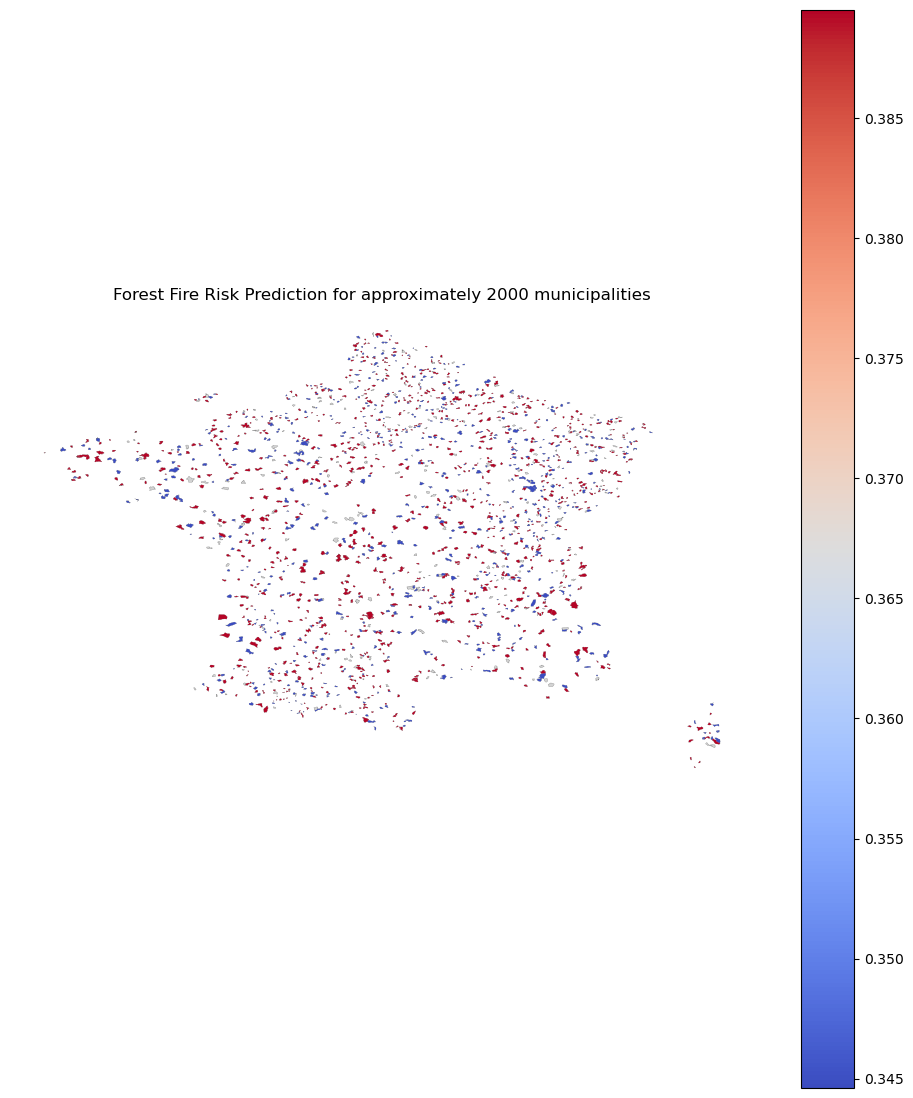

In [58]:
# Affichage de la carte
fig, ax = plt.subplots(figsize=(12, 14))
sample_gdf = gpd.GeoDataFrame(sample, geometry="geometry")
sample_gdf.plot(ax=ax, color="lightgrey", linewidth=0.2, edgecolor="grey")

gdf_predict.plot(
    ax=ax,
    column="proba",
    cmap="coolwarm",
    legend=True,
    linewidth=0.3
)

plt.title(f"Forest Fire Risk Prediction for approximately {nb_sample} municipalities")
plt.axis("off")
plt.show()